In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import time

In [2]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from nltk.stem.snowball import SnowballStemmer

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [4]:
from sklearn.decomposition import *
from sklearn.manifold import *
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [7]:
# Word2Vect
import gensim
import gensim.downloader as api

In [8]:
# Bert
import os
from transformers import TFAutoModel, AutoTokenizer

In [9]:
# BERT et USE
import tensorflow_hub as hub
import tensorflow_text 

In [10]:
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["TF_KERAS"]='1'

# Récupération des données

In [11]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'

In [12]:
data = pd.read_csv(path_csv)

## Transformation des données

Transformation de l'arbre de catégories en liste (et récupération de la première)

In [13]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [14]:
data['category'] = data['product_category_list'].apply(lambda l : l[0])

In [15]:
print("Liste des catégories retenues :")
print(data['category'].value_counts())

Liste des catégories retenues :
category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [16]:
list_cat = list(data['category'].value_counts().index)

In [17]:
# Convertion catégorie vers num
data['category_num'] = data['category'].apply(lambda e : list_cat.index(e))

On ne garde que les colonnes utiles

In [18]:
data = data[['product_name', 'product_category_list', 'description', 'category', 'category_num']].copy()
data.columns = ['name', 'category_list', 'description', 'category', 'category_num']

In [19]:
data

name   
0     Elegance Polyester Multicolor Abstract Eyelet ...  \
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                          category_list   
0     [Home Furnishing, Curtains & Accessories, Curt...  \
1     [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
2     [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
3     [Home Furnishing, Bed Linen, Bedsheets, SANTOS...   
4     [Home Furnishing, Bed Linen, Bedsheets, Jaipur...   
...                                                 ...   
1045  [Baby Care, Baby & Kids Gifts, Stickers, Oren ...   
1046  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...   
1047  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...   
1048  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...   
1049  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...   

                                            description         category   
0     Key Features of Elegance Polyester Multicolor ...  Home Furnishing  \
1     Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2     Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4     Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   
...                                                 ...              ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...        Baby Care   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        Baby Care   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        Baby Care   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        Baby Care   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        Baby Care   

      category_num  
0                0  
1                1  
2                1  
3                0  
4                0  
...            ...  
1045             1  
1046             1  
1047             1  
1048             1  
1049             1  

[1050 rows x 5 columns]

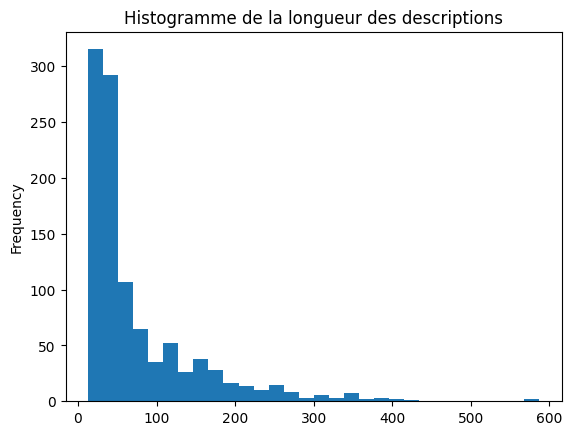

In [20]:
seq_len = [len(i.split()) for i in data['description']]

ax = pd.Series(seq_len).plot.hist(bins=30, title='Histogramme de la longueur des descriptions')

## Nettoyage du texte

In [21]:
# Initialisation du stemmer en anglais
stemmer = SnowballStemmer(language="english")

# Initialisation de spacy
nlp = spacy.load("en_core_web_sm")
# Ajout d'un outil pour séparer les phrases
nlp.add_pipe("sentencizer")

# Pour garder les négations
for n in ['no', 'not']:
    if n in STOP_WORDS:
        STOP_WORDS.remove(n)

In [22]:
# Fonction de transformation d'un texte vers une phrase
# Avec uniquement les tokens.
# Action séléctionne la transformation à appliquer au texte
# Cut permet de choisir la part du texte que l'on garde (1/2, 1/3 etc...)
def get_tokens(text, action='lemma', cut=1):
    doc = nlp(text)
    
    # Recapitalisation des phrases pour que Spacy les gères mieux
    text_tmp = ''
    # On sépare en phrases, les capitalises et on reforme le texte complet
    for sent in doc.sents:
        text_tmp += sent.text.capitalize() + ' '

    # On reanalyse le texte
    doc = nlp(text_tmp)

    filtered_tokens = []
    for token in doc:
        # On ignore la ponctuation et les espaces
        if not token.is_punct and not token.is_space:
            
            if action == 'lemma':
                normalized_token = token.lemma_.lower()
            elif action == 'norm':
                normalized_token = token.norm_.lower()
            elif action == 'stem':
                normalized_token = stemmer.stem(token.text.lower())
            else:
                normalized_token = token.text.lower()
            
            if normalized_token not in STOP_WORDS or action == 'base':
                filtered_tokens.append(normalized_token)
                
    return ' '.join(filtered_tokens[:int(len(filtered_tokens)/cut)]) # On ne garde qu'une portion du début de texte

In [23]:
print('Texte Lemmatisé :')
print(get_tokens("I don't like those 3 black cats, they are sitting on my single mat.", 'lemma'))

print('\nTexte Normalisé :')
print(get_tokens("I don't like those 3 black cats, they are sitting on my single mat.", 'norm'))

print('\nTexte Stemmé :')
print(get_tokens("I don't like those 3 black cats, they are sitting on my single mat.", 'stem'))

print('\nTexte :')
print(get_tokens("I don't like those 3 black cats, they are sitting on my single mat.", 'rien'))

print('\nTexte base :')
print(get_tokens("I don't like those 3 black cats, they are sitting on my single mat.", 'base'))

Texte Lemmatisé :
not like 3 black cat sit single mat

Texte Normalisé :
not like 3 black cats sitting single mat

Texte Stemmé :
like 3 black cat sit singl mat

Texte :
like 3 black cats sitting single mat

Texte base :
i do n't like those 3 black cats they are sitting on my single mat


Création du dataset final avec plusieurs version du texte transformé pour faire des tests et s'adapter aux différents algorithmes.
Dans tous les cas on ne garde que la première moitié du texte, la seconde diminuant beaucoup les performances

In [24]:
data_T = data.copy()

In [25]:
data_T['description_cut'] = [txt[:int(len(txt)/2)] for txt in data_T['description']]

In [26]:
data_T['description_text_stem_cut'] = data_T['description'].apply(lambda t : get_tokens(t, 'stem', 2))

data_T['description_text_lemma_cut'] = data_T['description'].apply(lambda t : get_tokens(t, 'lemma', 2))

data_T['description_text_norm_cut'] = data_T['description'].apply(lambda t : get_tokens(t, 'norm', 2))

In [27]:
data_T

name   
0     Elegance Polyester Multicolor Abstract Eyelet ...  \
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                          category_list   
0     [Home Furnishing, Curtains & Accessories, Curt...  \
1     [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
2     [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
3     [Home Furnishing, Bed Linen, Bedsheets, SANTOS...   
4     [Home Furnishing, Bed Linen, Bedsheets, Jaipur...   
...                                                 ...   
1045  [Baby Care, Baby & Kids Gifts, Stickers, Oren ...   
1046  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...   
1047  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...   
1048  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...   
1049  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...   

                                            description         category   
0     Key Features of Elegance Polyester Multicolor ...  Home Furnishing  \
1     Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2     Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4     Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   
...                                                 ...              ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...        Baby Care   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        Baby Care   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        Baby Care   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        Baby Care   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        Baby Care   

      category_num                                    description_cut   
0                0  Key Features of Elegance Polyester Multicolor ...  \
1                1  Specifications of Sathiyas Cotton Bath Towel (...   
2                1  Key Features of Eurospa Cotton Terry Face Towe...   
3                0  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                0  Key Features of Jaipur Print Cotton Floral Kin...   
...            ...                                                ...   
1045             1  Oren Empower Extra Large Self Adhesive Sticker...   
1046             1  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047             1  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048             1  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049             1  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                              description_text_stem_cut   
0     key featur eleg polyest multicolor abstract ey...  \
1     specif sathiya cotton bath towel 3 bath towel ...   
2     key featur eurospa cotton terri face towel set...   
3     key featur santosh royal fashion cotton print ...   
4     key featur jaipur print cotton floral king siz...   
...                                                 ...   
1045  oren empow extra larg self adhes sticker pack ...   
1046  wallmantra larg vinyl sticker sticker pack 1 p...   
1047  buy uberlyf extra larg pigment polyvinyl film ...   
1048  buy wallmantra medium vinyl sticker sticker rs...   
1049  buy uberlyf larg vinyl sticker rs.595 onlin ub...   

                             description_text_lemma_cut   
0     key feature elegance polyester multicolor abst...  \
1     specificat

# Préparation commune des traitements

In [28]:
print(data_T.shape)

(1050, 9)


In [29]:
l_cat = data_T['category'].unique()
y_cat_num = data_T['category_num']

## Fonctions communes

In [30]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, methode='tsne', n_components=2) :
    time1 = time.time()
    num_labels=len(l_cat)
    
    # TSNE à chaque fois pour la visualisation
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(features)
    
    # Puis réduction selon la méthode choisie
    if methode == 'tsne':
        X = X_tsne
    elif methode == 'nmf':
        model = NMF(n_components=n_components, init='random')
        X = model.fit_transform(features)
    elif methode == 'pca':
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
        model = PCA(n_components=n_components)
        X = model.fit_transform(features)
    elif methode == 'sparce_pca':
        model = SparsePCA(n_components=n_components)
        X = model.fit_transform(features.toarray())
    elif methode == 'isomap':
        model = Isomap(n_components=n_components)
        X = model.fit_transform(features.toarray())
    elif methode == 'mds':
        model = MDS(n_components=n_components)
        X = model.fit_transform(features.toarray())
        
    
    # Détermination des clusters à partir des données après la réduction 
    cls = KMeans(n_clusters=num_labels, n_init=100)
    cls.fit(X)
    
    # Calcul des résultats
    len_min = min(len(y_cat_num), len(cls.labels_))
    ARI = np.round(adjusted_rand_score(y_cat_num[:len_min], cls.labels_[:len_min]),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(l_cat), loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [31]:
# Petite fonction pour retrouver l'index de la valeur max
# d'un tableau 2D
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [32]:
# Fonction pour afficher sous forme de tableau les prédictions 
# et les targets en les arrangeants le long de la diagonale
def compare_clustering(original, predict, return_cat=False):
    original = list(original)
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)
    

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

# Bag of word - Tf-idf

## Préparation sentences

In [33]:
# Colonne de récupération des textes
feat = 'description_text_lemma_cut'

In [34]:
# On va travailler avec des NGram de mots
cvect = CountVectorizer(max_df=0.9, min_df=6, analyzer='word', ngram_range=(1, 4))
ctf = TfidfVectorizer(max_df=0.9, min_df=6, analyzer='word', ngram_range=(1, 4))

#cvect = CountVectorizer(max_df=0.80, min_df=15, analyzer='char', ngram_range=(5, 7))
#ctf = TfidfVectorizer(max_df=0.80, min_df=15, analyzer='char', ngram_range=(5, 7))

#cvect = CountVectorizer(max_df=0.95, min_df=3)
#ctf = TfidfVectorizer(max_df=0.95, min_df=3)

cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

### Analyse de la vectorisation

In [35]:
print("Taille du vocabulaire Count :", len(cvect.get_feature_names_out()))
print("Taille du vocabulaire Tf-Idf :", len(ctf_fit.get_feature_names_out()))

Taille du vocabulaire Count : 1921
Taille du vocabulaire Tf-Idf : 1921


In [36]:
# Obtention des mots triés par fréquence décroissante
vocab = cvect.get_feature_names_out()
counts = np.asarray(cv_transform.sum(axis=0)).ravel()
df = pd.DataFrame({"mot": vocab, "nb occurences": counts})
df = df.sort_values("nb occurences", ascending=False)

print("Mots les plus présents :\n", df.head(10))

print("\nMots les moins présents :\n", df.tail(10))

Mots les plus présents :
                 mot  nb occurences
1509             rs            705
317             buy            572
1356          price            346
1221         online            339
1845          watch            306
1360       price rs            301
729         feature            259
1120            mug            258
196          analog            257
1694  specification            246

Mots les moins présents :
                                    mot  nb occurences
121             95a connector pin size              6
1493        right adapter laptop check              6
1492              right adapter laptop              6
1491                     right adapter              6
365                 ceramic coffee mug              6
364                     ceramic coffee              6
1478  requirment laptop adapter output              6
1477         requirment laptop adapter              6
1476                 requirment laptop              6
960                  

In [37]:
feature_names = ctf_fit.get_feature_names_out()
idf_scores = ctf_fit.idf_

df = pd.DataFrame([feature_names, idf_scores], index=['nom', 'score']).T
df = df.sort_values('score', ascending=False)

print("Mots les plus importants :\n", df.head(10))

print("\nMots les moins représentatifs :\n", df.tail(10))

Mots les plus importants :
                             nom     score
960                        kind  6.011587
937                   intellect  6.011587
1768                      think  6.011587
1766                 technology  6.011587
643   double blanket multicolor  6.011587
647                double quilt  6.011587
648      double quilt comforter  6.011587
654                         dsl  6.011587
656                   dual band  6.011587
662                       duvet  6.011587

Mots les moins représentatifs :
                 nom     score
756        flipkart     2.759
949     key feature   2.64923
948             key  2.644291
1694  specification  2.485227
729         feature   2.46856
1360       price rs   2.24707
1356          price  2.131497
1221         online  2.128552
317             buy  1.608358
1509             rs  1.397882


## Exécution des modèles

In [38]:
print("Version avec PCA")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform, 'sparce_pca', 4)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform, 'sparce_pca', 6)

Version avec PCA
CountVectorizer : 
-----------------
ARI :  0.1198 time :  34.0

Tf-idf : 
--------
ARI :  0.1066 time :  17.0


In [39]:
print("Version avec NMF")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform, 'nmf', 4)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform, 'nmf', 6)

Version avec NMF
CountVectorizer : 
-----------------
ARI :  0.0936 time :  15.0

Tf-idf : 
--------
ARI :  0.2649 time :  12.0


In [40]:
print("Version avec T-SNE")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform)

Version avec T-SNE
CountVectorizer : 
-----------------
ARI :  0.3516 time :  15.0

Tf-idf : 
--------
ARI :  0.5418 time :  13.0


## Graphiques

In [41]:
list_cat = list(data_T['category'])

Version T-SNE + CountVectorizer :

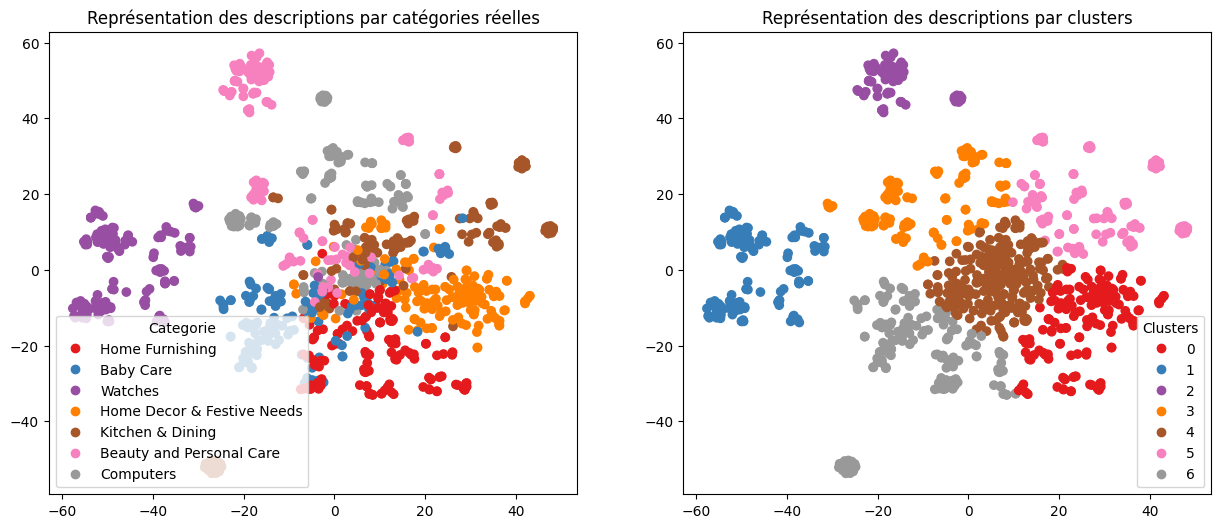

ARI :  0.3516


In [42]:
TSNE_visu_fct(X_tsne_cv, y_cat_num, labels_cv, ARI_cv)

In [43]:
compare_clustering(list_cat, labels_cv)

ARI :  0.35163332586781637


Version T-SNE + Tf-idf :

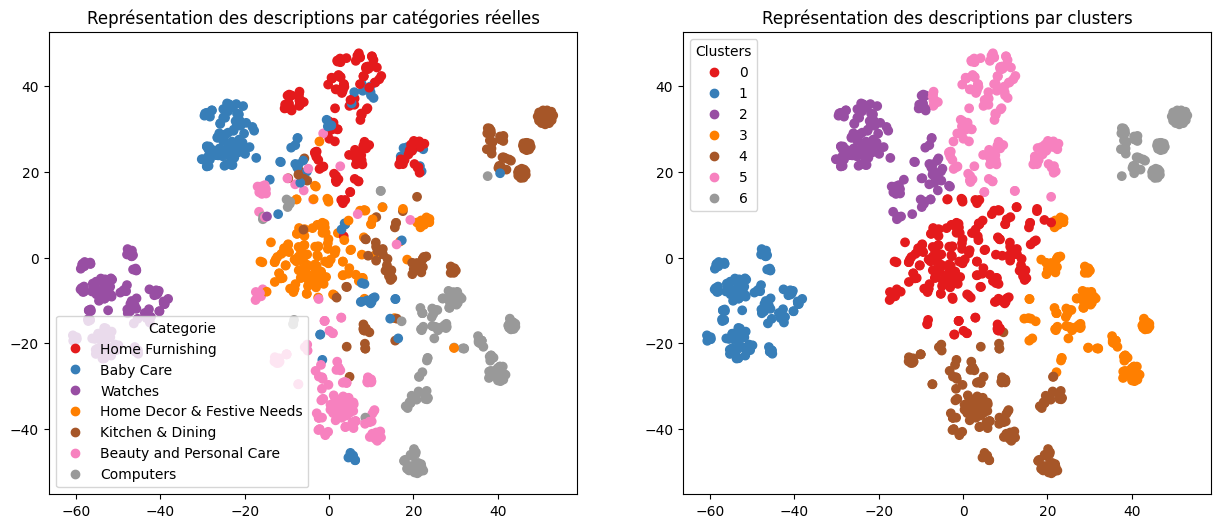

ARI :  0.5418


In [44]:
TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels_ctf, ARI_ctf)

In [45]:
compare_clustering(list_cat, labels_ctf)

ARI :  0.5418393167439438


# Word2Vec

In [46]:
feat = 'description_text_norm_cut'

## Création du modèle Word2Vec

Préparation et tokenisation des descriptions

In [47]:
sentences = data_T[feat].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [48]:
print("Taille moyenne des descriptions :")
print(np.mean([len(s) for s in sentences]))

Taille moyenne des descriptions :
25.83142857142857


In [49]:
maxlen = 24

In [50]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4220


Préparation et paramètrage du modèle

In [51]:
w2v_size = 12
w2v_window = 4
w2v_min_count = 2
w2v_epochs = 100

In [52]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                workers=3)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

Build & train Word2Vec model ...


In [53]:
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 2475
Word2Vec trained


## Création de la matrice d'embedding

In [54]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.5866
Embedding matrix: (4220, 12)


## Création du modèle d'embedding

In [55]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 12)            50640     
                                                                 
 global_average_pooling1d (G  (None, 12)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 50,640
Trainable params: 50,640
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [56]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 635us/step


(1050, 12)

Version PCA
ARI :  0.327 time :  15.0


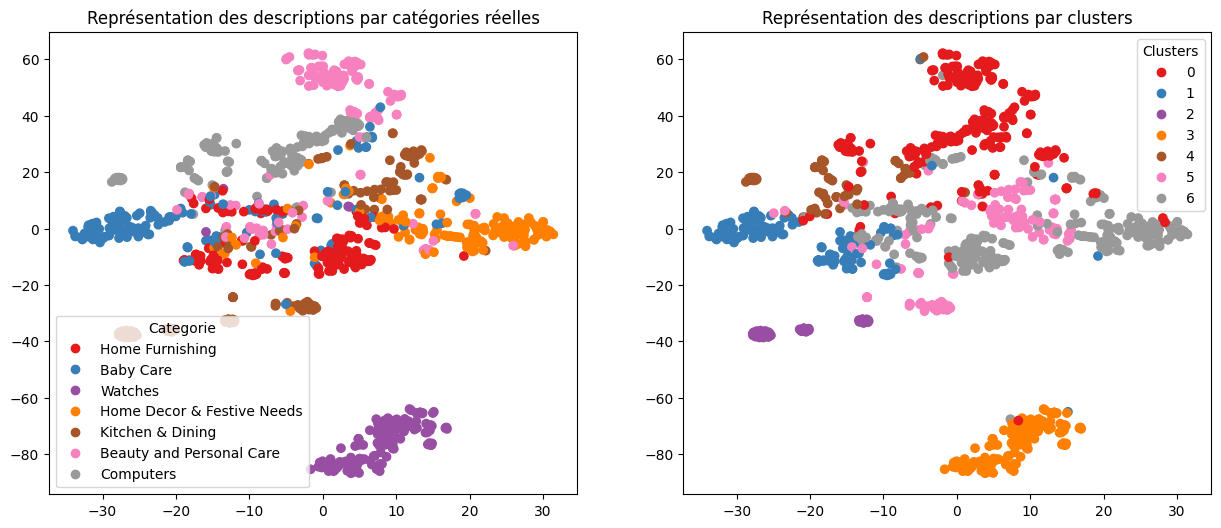

ARI :  0.327


In [57]:
print("Version PCA")
ARI, X_tsne, labels = ARI_fct(embeddings, 'pca', 4)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version T-SNE
ARI :  0.5212 time :  14.0


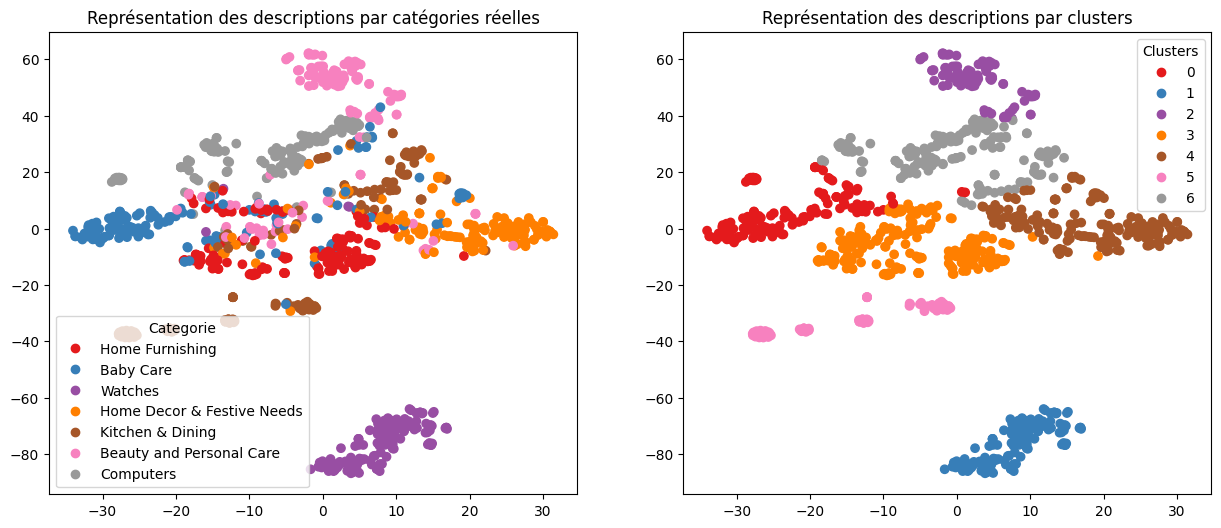

ARI :  0.5212


In [58]:
print("Version T-SNE")
ARI, _, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [59]:
feat = 'description_cut'

## Fonctions communes

In [60]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [61]:
max_length = 24
batch_size = 25
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T[feat].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [62]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step
temps traitement :  56.0


Version PCA
ARI :  0.3368 time :  14.0


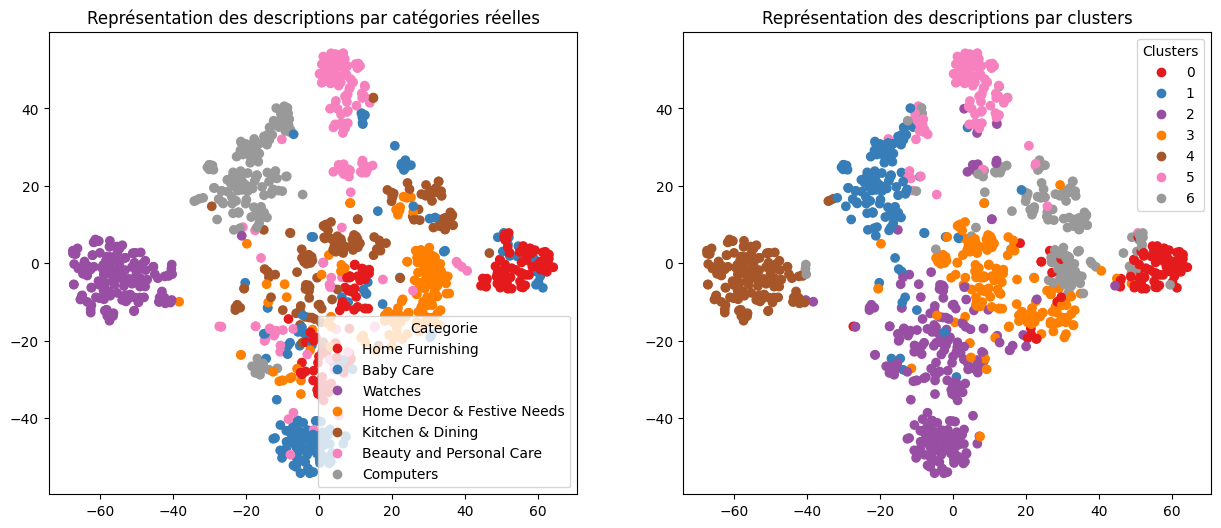

ARI :  0.3368


In [63]:
print("Version PCA")
ARI, X_tsne, labels = ARI_fct(features_bert, 'pca', 5)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version T-SNE
ARI :  0.4912 time :  15.0


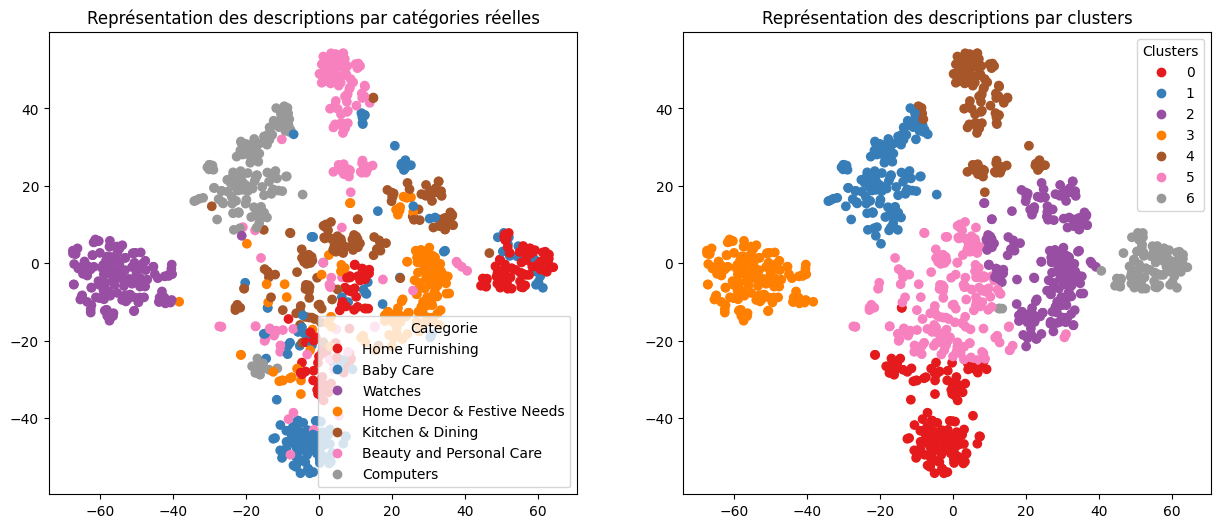

ARI :  0.4912


In [64]:
print("Version T-SNE")
ARI, _, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [65]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [66]:
sentences = data_T[feat].to_list()

In [67]:
max_length = 24
batch_size = 25
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  54.0


Version PCA
ARI :  0.3358 time :  14.0


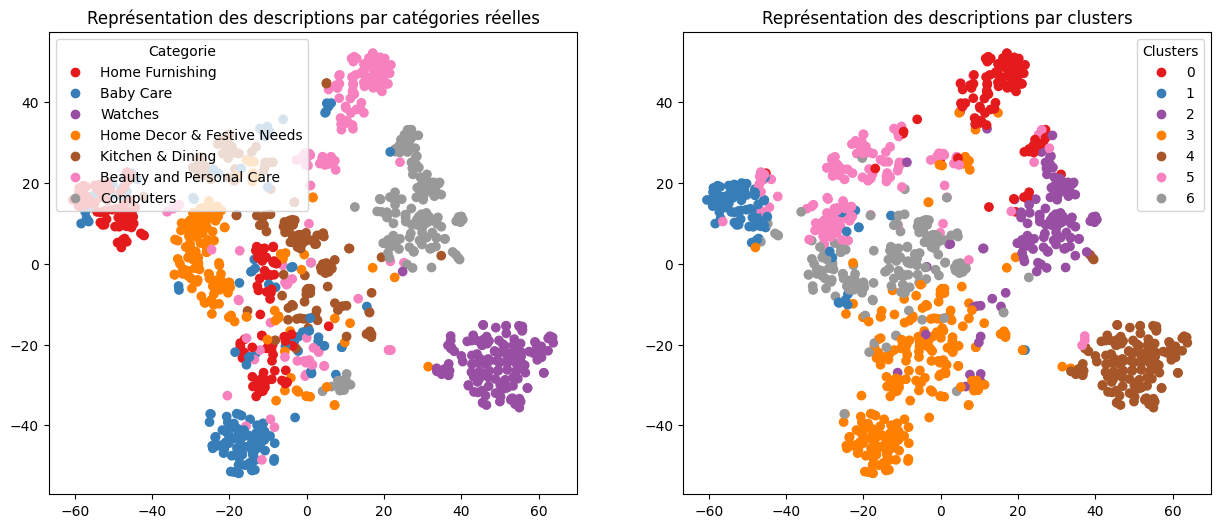

ARI :  0.3358


In [68]:
print("Version PCA")
ARI, X_tsne, labels = ARI_fct(features_bert, 'pca', 5)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version T-SNE
ARI :  0.4634 time :  14.0


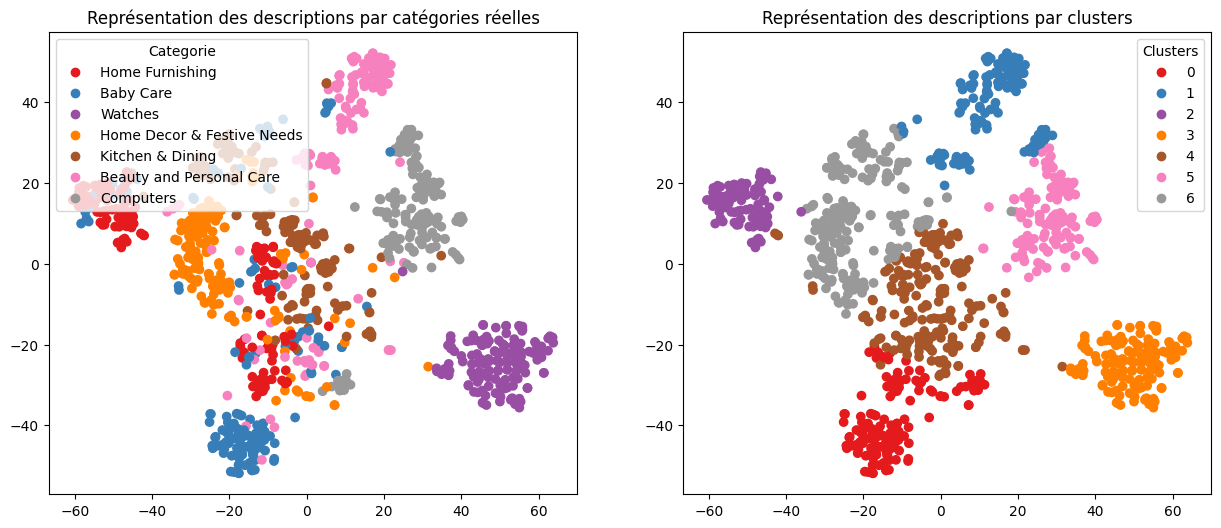

ARI :  0.4634


In [69]:
print("Version T-SNE")
ARI, _, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [70]:
# Chargement du modèle
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [71]:
# Utilisation des données brutes (mais coupées)
feat = 'description_cut'

In [72]:
sentences = data_T[feat].to_list()

In [73]:
# Transformation
features_USE = embed(sentences)

Version PCA
ARI :  0.3534 time :  14.0


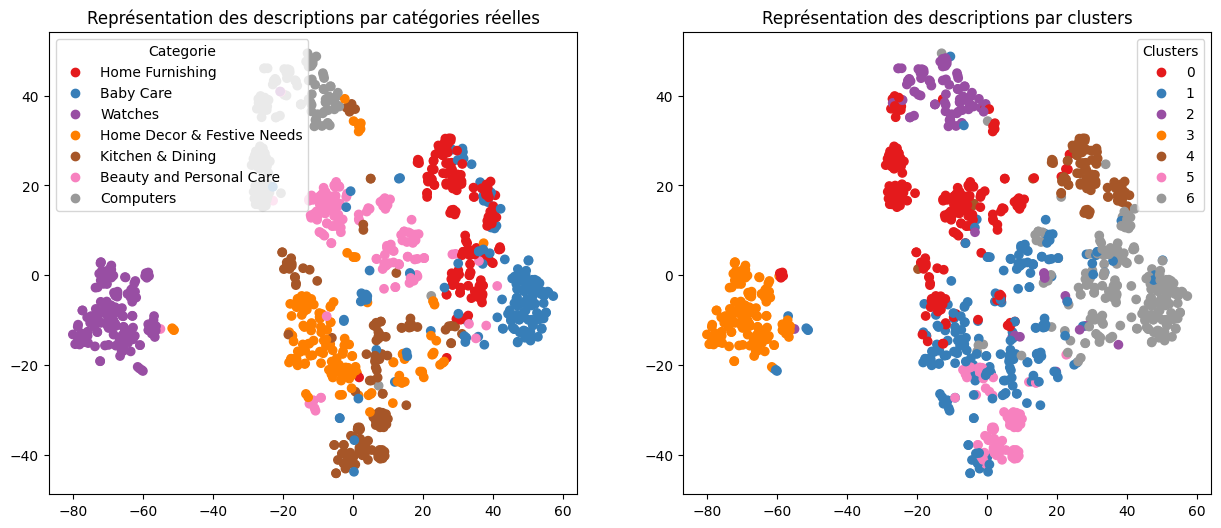

ARI :  0.3534


In [74]:
print("Version PCA")
ARI, X_tsne, labels = ARI_fct(features_USE, 'pca', 4)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version T-SNE
ARI :  0.6184 time :  12.0


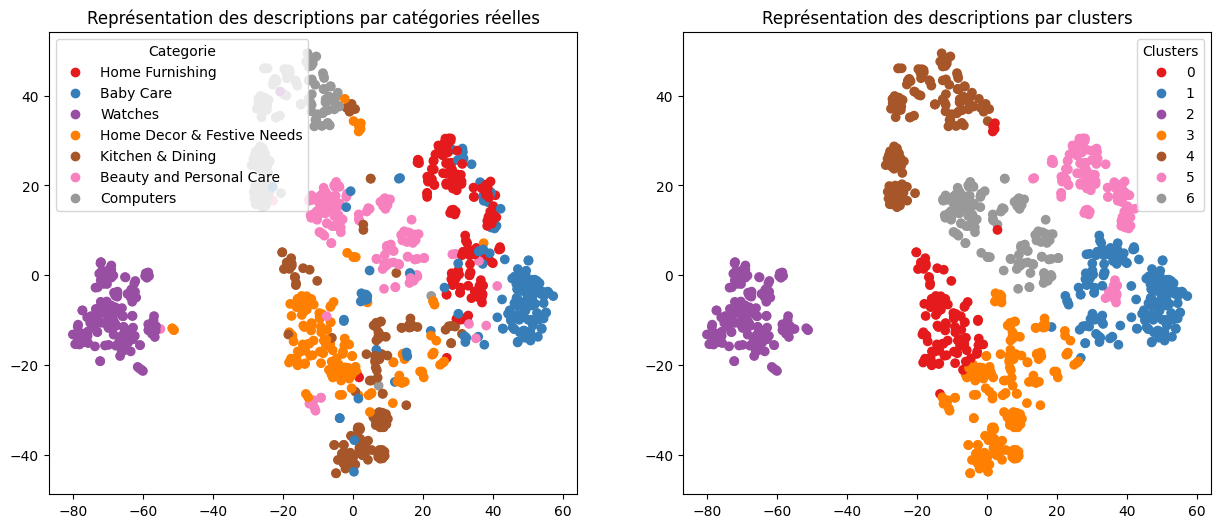

ARI :  0.6184


In [75]:
print("Version T-SNE")
ARI, _, labels = ARI_fct(features_USE)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [76]:
compare_clustering(data_T['category'].to_list(), labels)

ARI :  0.6184494709910285


In [77]:
list_cat, list_col = compare_clustering(data_T['category'].to_list(), labels, True)

In [78]:
tmp = data_T[['category', 'description']].copy()
tmp['label'] = labels

In [79]:
@interact
def show_img(reel=list_cat, predit=list_cat, index=range(0, 10)):
    predit = list_cat.index(predit)
    predit = list_col[predit]
    predit = int(predit[5:])
    
    extract = tmp.loc[(tmp['category']==reel) &  (tmp['label']==predit), 'description']
    
    if len(extract) <= index:
        return "Rien"
    
    return extract.iloc[index]

interactive(children=(Dropdown(description='reel', options=('Watches', 'Computers', 'Beauty and Personal Care'…

In [80]:
df = pd.DataFrame(X_tsne, columns=['x', 'y'])
df['cat'] = data_T['category']
df['txt'] = data_T['description']

In [81]:
fig = px.scatter(df, x="x", y="y", color="cat", hover_data="txt")
fig

### Quelques tests indépendants de USE

In [82]:
from scipy.spatial import distance_matrix

In [83]:
textes = [
    "Man",
    "Dog",
    "Princess",
    "Women",
    "Bird",
    "Sun",
    "Apple"
]

In [84]:
features_USE = embed(textes)
distance = distance_matrix(features_USE, features_USE)
pd.DataFrame(distance, index=textes, columns=textes).style.background_gradient(cmap="viridis")

In [85]:
textes = [
    "Hello, my dear friend ! How are you",
    "Happy to see you !",
    "You can take my phone if you want.",
    "She stabs him with a fork",
    "Stir the flour, baking powder and a pinch of salt together",
    "Noticeboards keep everyone up to date and make great little display areas for personal touches",
    "Those are beautiful cookies",
    "It's a cake",
    "It's a piece of cake",
    "It's very easy",
    "I will destroy everything",
    "It is cool",
    "It",
    "This",
]

In [86]:
textes = [get_tokens(txt, 'base') for txt in textes]

In [87]:
features_USE = embed(textes)

In [88]:
distance = distance_matrix(features_USE, features_USE)

In [89]:
distance = pd.DataFrame(distance, index=[txt[:20] for txt in textes], columns=[txt[:10] for txt in textes])

In [90]:
distance.style.background_gradient(cmap="viridis")